In [1]:
%load_ext autoreload
%autoreload 2
import jupyter_black

jupyter_black.load(line_length=79)

In [2]:
from glob import glob

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict

import src.alpha_queue_reactive as aqr
from src.qr_params import QRParams

### Initialising Parameters

In [3]:
# This is a small utility that I use to load my files
# I precompute some relevant quantities in and estimations
# folder that I aggregate over a date range of my choice to
# get QR statistics estimations. This class helps me do that
# My estimation files are very close to what your research/run/ferrari/alpha.py
# script outputs if I am not mistaken.
loader: QRParams = QRParams(data_dir="data/QR/v1")

ticker = "AAL"
model_rng = np.random.default_rng(1337)
lob_rng = np.random.default_rng(42)

lob_params = {
    "bid_prices": [999, 1000],
    "bid_volumes": [2, 3],
    "ask_volumes": [5, 7],
    "ask_prices": [1002, 1003],
}
lob = aqr.config.init_lob(loader, ticker, **lob_params, lob_rng=lob_rng)

In [4]:
# I created a little utility to parse json configs for SLURM jobs at first but
# find it actually handy
config = {
    "ticker": "AAL",
    "qr_offset": 0,  # This is added to the QR deltat
    "alpha": {
        "type": "imbalance",
        # This I need to look over
        # "params": {
        #     "lamda": 1_000_000_000,
        #     "race_params": {
        #         "type": "simple_race",
        #         "params": {
        #             "race_id": 2,
        #             "theta_N": 0.5,
        #             "theta_p": 0.25,
        #             "alpha_threshold": 0.7,
        #             "max_spread": 1,
        #             "event_weights": [0.48, 0.48, 0.04],
        #         },
        #     },
        # },
    },
    "matching_engine": {
        "l1": 911 + 271 + 665,
        "l2": 919 + 911,
        "delta": 30000,  # I take delta to be constant 30 microseconds here
        "gamma": 0.25,  # Here the parameter is a quantile level, gamma is
        # taken as the distribution of delta_t | delta_t < quantile(delta_t) basically
    },
    "race_model": {
        "type": "simple_race",
        "params": {
            "race_id": 1,
            "theta_N": 0.3,  # N orders are sampled in the simple race from a geometric distribution of this parameter
            "theta_p": 0.5,  # This is the probability a race happens when the alpha is above the threshold
            "alpha_threshold": 0.5,
            "max_spread": 1,  # Races are only triggered when the spread is leq than max_spread
            "event_weights": [0.5, 0.5],
        },
    },
    "external_event_model": {
        "type": "no_event",
        "params": {
            "lamda": 1e6,
            "race_id": 2,  # I give it a race_id even though it's not necessarily a race to indentify it
            "theta": 0.1,
        },
    },
    "trader": {
        "trader_id": 1,
        "max_spread": 1,  # The trader will not send any orders for spreads beyond this
        "max_volume": 5,  # The trader will always send trades of this size, he might be fully or partially filled
        "alpha_threshold": 0.5,
        "max_pos": 5,
        "probability_": 0.25,  # Probability he trades when the alpha is above the threshold
    },
}

aqr_params = {
    **aqr.config.parse_config(config, loader, model_rng),
    "rng": model_rng,
}

aqr_model = aqr.alpha_qr.AQR(**aqr_params)

In [5]:
!rm -rf tmp
buffer = aqr.buffer.Buffer(max_size=10_000, checkpoint_dir="tmp")
aqr_model.sample(
    lob, max_ts=int(1e9 * 3600 * 5.5), buffer=buffer
)  # 5.5 hours of trading

Checkpoint saved to tmp/checkpoint_0.parquet
Checkpoint saved to tmp/checkpoint_1.parquet
Checkpoint saved to tmp/checkpoint_2.parquet
Checkpoint saved to tmp/checkpoint_3.parquet
Checkpoint saved to tmp/checkpoint_4.parquet
Checkpoint saved to tmp/checkpoint_5.parquet
Checkpoint saved to tmp/checkpoint_6.parquet
Checkpoint saved to tmp/checkpoint_7.parquet
Checkpoint saved to tmp/checkpoint_8.parquet
Checkpoint saved to tmp/checkpoint_9.parquet


In [6]:
df = (
    pl.concat(
        [
            *[pl.scan_parquet(f) for f in glob("tmp/*.parquet")],
            buffer.to_df().lazy(),
        ]
    )
    .sort(by="dt")
    .collect()
)

In [7]:
# Order book related column like P_{i} and Q_{i} either have _event or _recv
# _event means that it's the order book state from which the event originated
# and _recv is the state when the order was received by market participants.
# Imbalance spread and alpha values are recorded when the event is sent not received
# Alpha here is redundant since it's the imbalance
df.head()

sequence,ts,xt,dt,imbalance,spread,alpha,side,price,size,event,partial,rejected,race,trader_id,trader_pos,P_-4_event,P_-3_event,P_-2_event,P_-1_event,Q_-4_event,Q_-3_event,Q_-2_event,Q_-1_event,Q_1_event,Q_2_event,Q_3_event,Q_4_event,P_1_event,P_2_event,P_3_event,P_4_event,P_-4_recv,P_-3_recv,P_-2_recv,P_-1_recv,Q_-4_recv,Q_-3_recv,Q_-2_recv,Q_-1_recv,Q_1_recv,Q_2_recv,Q_3_recv,Q_4_recv,P_1_recv,P_2_recv,P_3_recv,P_4_recv
i64,i64,i64,i64,f64,i64,f64,i8,i64,i64,str,bool,bool,i8,i8,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,377451,379298,411128,-0.25,2,-0.25,-1,1001,21,"""Create_Bid""",false,false,0,0,0,997,998,999,1000,22,20,2,3,5,7,14,19,1002,1003,1004,1005,997,998,999,1000,22,20,2,3,5,7,14,19,1002,1003,1004,1005
1,411128,412975,444805,0.615385,1,0.615385,1,1002,1,"""Can""",false,false,1,0,0,998,999,1000,1001,20,2,3,21,5,7,14,19,1002,1003,1004,1005,998,999,1000,1001,20,2,3,21,5,7,14,19,1002,1003,1004,1005
2,411128,412975,458967,0.68,1,0.68,1,1002,1,"""Trd""",false,false,1,0,0,998,999,1000,1001,20,2,3,21,5,7,14,19,1002,1003,1004,1005,998,999,1000,1001,20,2,3,21,4,7,14,19,1002,1003,1004,1005
3,411128,412975,470681,0.75,1,0.75,1,1002,1,"""Can""",false,false,1,0,0,998,999,1000,1001,20,2,3,21,5,7,14,19,1002,1003,1004,1005,998,999,1000,1001,20,2,3,21,3,7,14,19,1002,1003,1004,1005
4,411128,412975,475353,0.826087,1,0.826087,1,1002,3,"""Can""",true,false,1,0,0,998,999,1000,1001,20,2,3,21,5,7,14,19,1002,1003,1004,1005,998,999,1000,1001,20,2,3,21,2,7,14,19,1002,1003,1004,1005


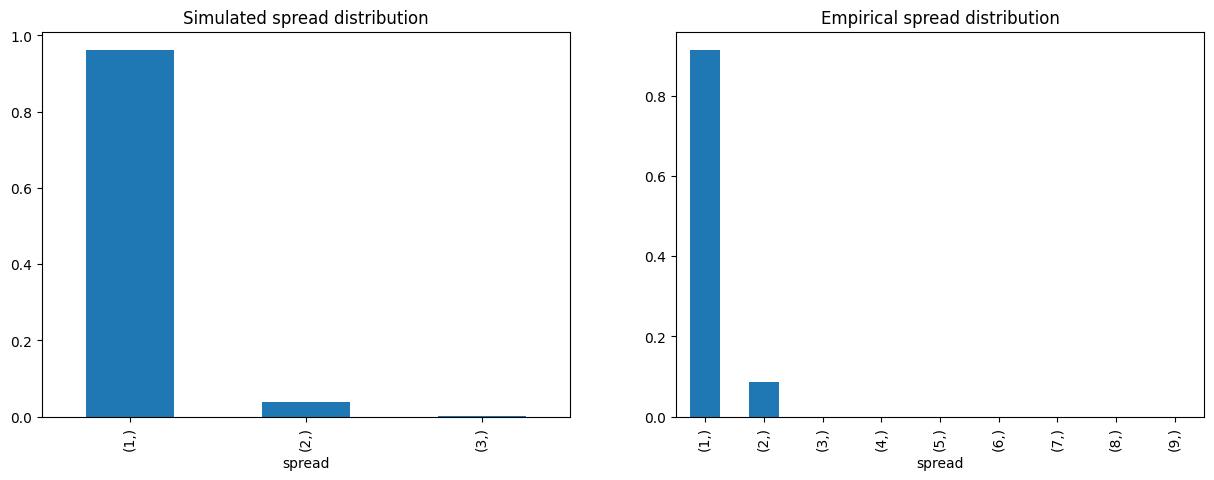

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df.select(
    pl.col("spread").filter(~pl.col("rejected"))
).to_pandas().value_counts(normalize=True).sort_index().plot(
    kind="bar", ax=ax1
)

loader.load_raw_files(ticker=ticker).select(
    "spread"
).collect().to_pandas().value_counts(normalize=True).sort_index().plot(
    kind="bar", ax=ax2
)

ax1.set_title("Simulated spread distribution")
ax2.set_title("Empirical spread distribution")
plt.show()

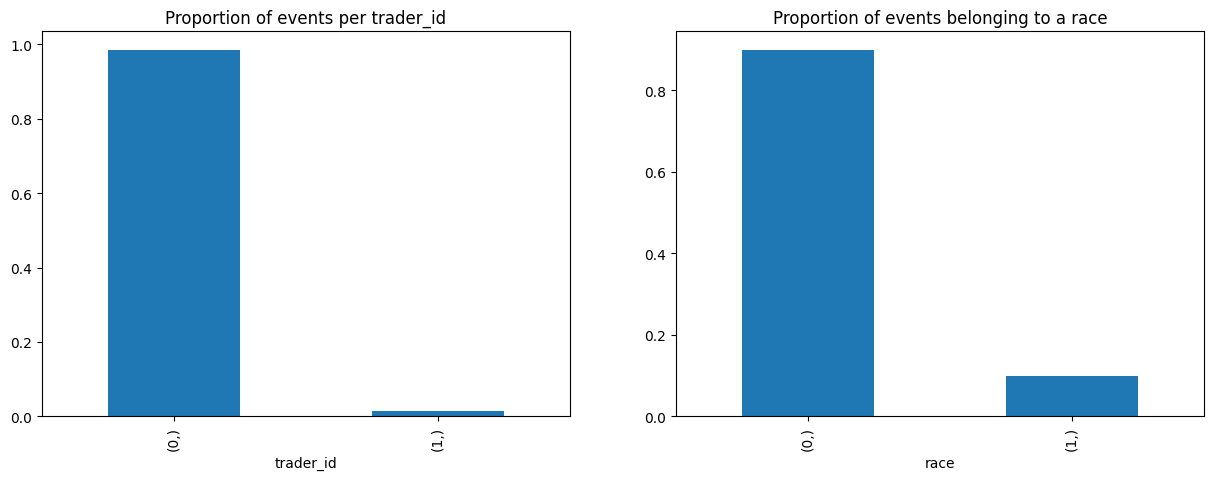

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df.select(
    pl.col("trader_id").filter(~pl.col("rejected"))
).to_pandas().value_counts(normalize=True).plot(kind="bar", ax=ax1)

df.filter(pl.col("rejected").eq(False)).select(
    "race"
).to_pandas().value_counts(normalize=True).plot(kind="bar", ax=ax2)

ax1.set_title("Proportion of events per trader_id")
ax2.set_title("Proportion of events belonging to a race")
plt.show()

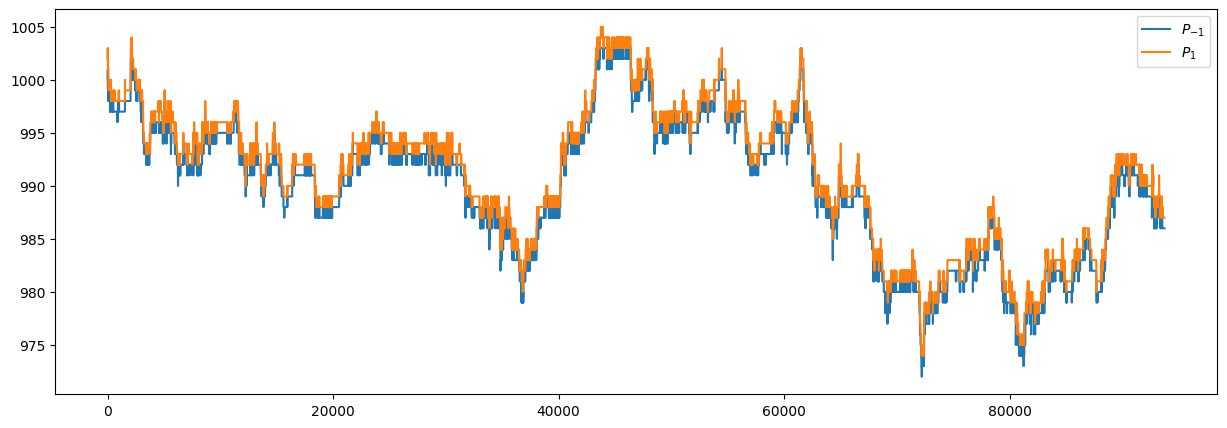

In [10]:
plt.figure(figsize=(15, 5))

plt.plot(
    df.select(pl.col("P_-1_event").filter(~pl.col("rejected"))),
    label=r"$P_{-1}$",
)
plt.plot(
    df.select(pl.col("P_1_event").filter(~pl.col("rejected"))), label=r"$P_1$"
)

plt.legend()
plt.show()

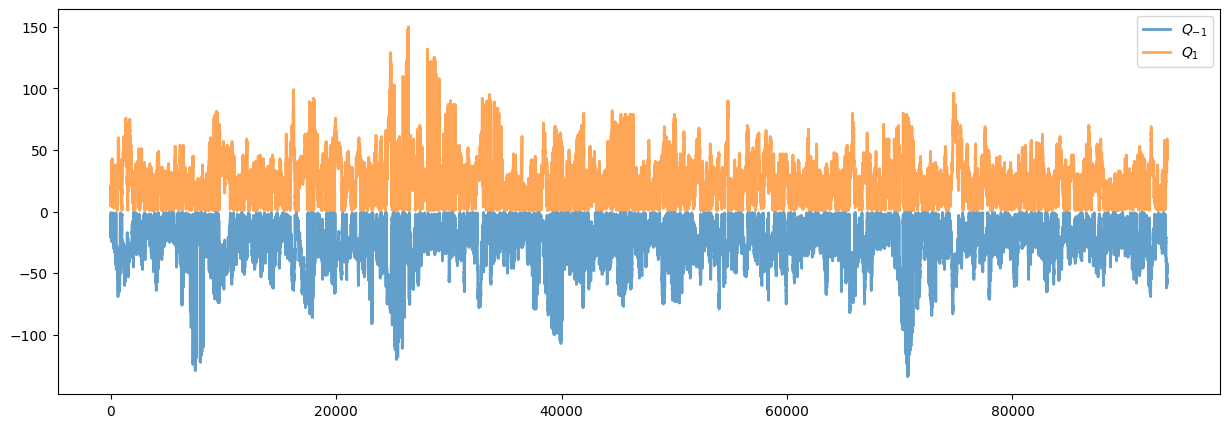

In [11]:
# Queue sizes appear to be reasonable
plt.figure(figsize=(15, 5))

plt.plot(
    df.select(-pl.col("Q_-1_event").filter(~pl.col("rejected"))),
    label=r"$Q_{-1}$",
    lw=2,
    alpha=0.7,
)
plt.plot(
    df.select(pl.col("Q_1_event").filter(~pl.col("rejected"))),
    label=r"$Q_1$",
    lw=2,
    alpha=0.7,
)

plt.legend()
plt.show()

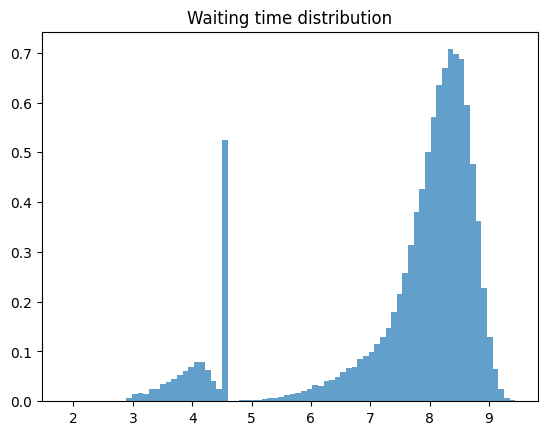

In [13]:
plt.hist(
    df.select(
        pl.col("dt").filter(~pl.col("rejected")).diff().drop_nulls()
    ).select(pl.col("dt").filter(pl.col("dt").gt(0)).log10()),
    bins=80,
    alpha=0.7,
    density=True,
)

plt.title("Waiting time distribution")
plt.show()

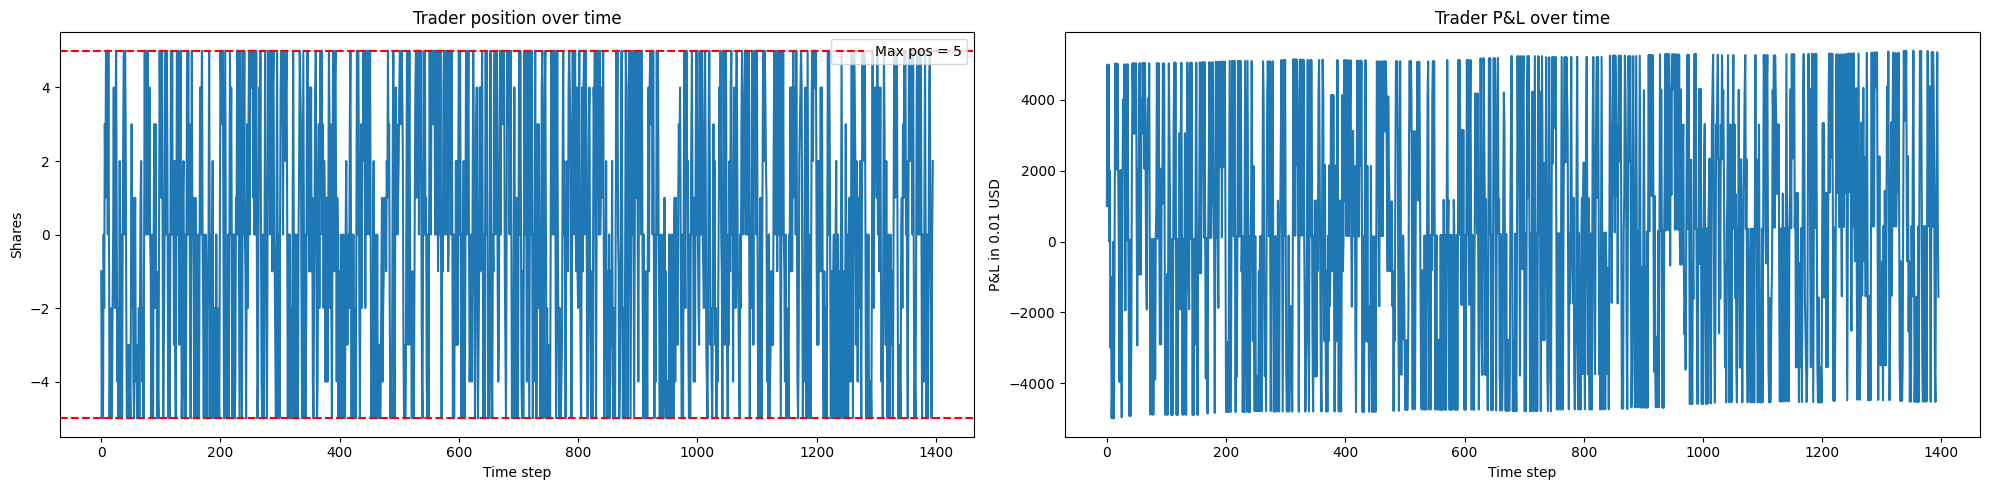

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(
    df.select(
        pl.col("size")
        .mul("side")
        .filter(pl.col("trader_id").eq(1) & pl.col("rejected").eq(False))
        .cum_sum()
    )
)

ax1.axhline(
    y=aqr_model.trader.max_pos,
    color="red",
    linestyle="--",
    label=f"Max pos = {aqr_model.trader.max_pos}",
)
ax1.axhline(y=-aqr_model.trader.max_pos, color="red", linestyle="--")

ax1.set_title("Trader position over time")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Shares")
ax1.legend()

ax2.plot(
    df.select(
        pl.col("size")
        .mul("side")
        .mul("price")
        .mul(-1)
        .filter(pl.col("trader_id").eq(1) & pl.col("rejected").eq(False))
        .cum_sum()
    )
)
ax2.set_title("Trader P&L over time")
ax2.set_xlabel("Time step")
ax2.set_ylabel("P&L in 0.01 USD")

fig.tight_layout()
plt.show()
plt.close()

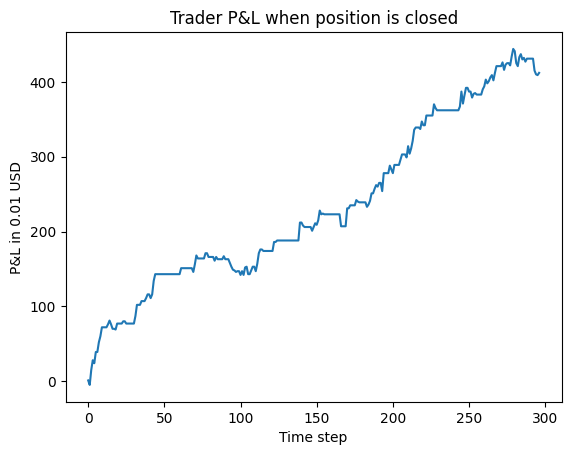

In [28]:
plt.plot(
    df.filter(pl.col("trader_id").eq(1) & pl.col("rejected").eq(False))
    .select(
        pl.col("size").mul("side").mul("price").mul(-1).cum_sum().alias("pnl"),
        pl.col("size").mul("side").cum_sum().alias("pos"),
    )
    .select(pl.col("pnl").filter(pl.col("pos").eq(0)))
)

plt.title("Trader P&L when position is closed")
plt.xlabel("Time step")
plt.ylabel("P&L in 0.01 USD")

plt.show()